In [1]:
import numpy as np
import pandas as pd
from scipy import sparse, special, stats

# Perceptual Simulation
import scipy.stats as stats

# We set the hit rate to 0.75 and assume Clockwise is the signal (1:CW, 0:CCW)
Goal_Hit_Prob = 0.75
signal_mean = 1 
noise_mean = 0
criterion = 0.5 # we assume the criterion is 0.5, since the two orientations are equally likely
common_std = 0.7413011092528007

# import arviz as az
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import constrNMPy
# import os 
# import warnings

# from matplotlib import gridspec
# from scipy import sparse, special, stats

# %config InlineBackend.figure_format = 'retina'
# warnings.simplefilter(action="ignore", category=FutureWarning)

# # color pallette
# [gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
# [vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# # set the style of the plots
# az.style.use("arviz-white")
# from matplotlib import rcParams
# rcParams['font.family'] = 'Arial'

In [9]:
# The perception process is reduced to a SDT model
def Data_Gen(trialnum, 
             signal_mean = 1, noise_mean = 0, criterion = 0.5, std = 0.7413011092528007):
    '''
    Generate data with noise for a given number of trials.
    '''
    samples_1 = np.random.normal(signal_mean, std, int(trialnum/2))
    labels_1 = np.ones(int(trialnum/2))
    samples_2 = np.random.normal(noise_mean, std, int(trialnum/2))
    labels_2 = np.zeros(int(trialnum/2))
    samples = np.concatenate((samples_1, samples_2), axis=0)
    labels = np.concatenate((labels_1, labels_2), axis=0)
    # shuffle the data
    idx = np.arange(trialnum)
    np.random.shuffle(idx)
    samples = samples[idx]
    labels = labels[idx]
    likelihood_signal = stats.norm.cdf(samples, criterion, std)
    likelihood_noise = 1 - stats.norm.cdf(samples, criterion, std)
    likelihood = np.vstack((likelihood_noise,likelihood_signal))
    return samples, labels, likelihood


# Simulate the Reinforcement Learning process per trial

def RL_3_per_trial(posterior, subj_state, Q, label, learning_rate, reward = 1, punishment = 0):
    '''
    Simulate the Reinforcement Learning model 2 process per trial.
    param posterior: the posterior probability of the signal : [\  /], this model is just likelihood
    param subj_state: the mapping of the response key (state_space):
        1 - [ \ ] [ \ / ]
        2 - [ \ ] [ / \ ]
        3 - [ / ] [ \ / ]
        4 - [ / ] [ / \ ]
    param Q: the Q table of the RL model, 2 by 2 matrix, [[s_1_v_L, s_1_v_R]; [s_2_v_L, s_2_v_R]; [s_3_v_L, s_3_v_R]; [s_4_v_L, s_4_v_R]]
    param label: the label of the stimulus: 1 for CW / and 0 for CCW \ 
    param learning_rate: the learning rate of the RL model
    param reward/punishment: the reward and punishment value for the correct response
    
    Return: 
    action: the action chosen by the model, -1 for left and 1 for right
    resp_ori: the orientation of the response, 1 for CW / and 0 for CCW \ 
    feedback: the feedback given by the environment, 1 for correct and 0 for incorrect
    Q: the updated Q table
    '''
    key_mapping = {-1: [0, 1, 0, 1], 1: [1, 0, 1, 0]}
    
    if subj_state in [1, 3]:
        posterior_arrange = posterior
    else:
        posterior_arrange = posterior[::-1]
        
    # choose the action with the larger utility and receive the feedback
    U_L = posterior_arrange[0] * Q[subj_state - 1, 0]
    U_R = posterior_arrange[1] * Q[subj_state - 1, 1]
    action = np.sign(U_R - U_L)
    resp_ori = key_mapping[action][subj_state - 1]
    feedback = int(resp_ori == label)
    
    # update the value of the chosen action
    if action == -1:
        Q[subj_state - 1, 0] = (1 - learning_rate) * Q[subj_state - 1, 0] + learning_rate * feedback
    else:
        Q[subj_state - 1, 1] = (1 - learning_rate) * Q[subj_state - 1, 1] + learning_rate * feedback
        
    return action, resp_ori, feedback, Q

# SD_calculation helper functions
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

def process_data_percept_cb(data, back):
    """Return hits and false alarms for a specific n-back"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

def calculate_sd_nback_percept_cb(all_data, maxsubj = 30, maxblock = 20, num_backs = 10):
    SD_nback_Percept_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_percept_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_n"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[key]["Hit"])
            fas = np.concatenate(temp_data[key]["FA"])
            hits_n = np.concatenate(temp_data[key]["Hit_n"])
            fas_n = np.concatenate(temp_data[key]["FA_n"])
            cs = criterion(np.mean(hits_n)*0.99 + 0.005, np.mean(fas_n)*0.99 + 0.005) - criterion(np.mean(hits)*0.99 + 0.005, np.mean(fas)*0.99 + 0.005)
            SD_nback_Percept_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Percept_cb)


def process_data_motor_cb(data, back):
    """Return hits and false alarms for motor responses"""
    hit_L, fa_L = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Qualified'] == True)])
    hit_R, fa_R = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Qualified'] == True)])
    return (hit_L, fa_L, hit_R, fa_R)

def calculate_sd_nback_motor_cb(all_data, maxsubj = 30, maxblock = 20, num_backs = 10):
    SD_nback_Motor_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

    for iS in range(1, maxsubj + 1):
        subject_data = all_data[iS]
        temp_data = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}

        for iB in range(1, maxblock + 1):
            for back in range(1, num_backs + 1):
                block_data = subject_data[iB - 1]
                hits_fa = process_data_motor_cb(block_data, back)
                temp_data[f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[f"{back}_back"]["FA_R"].append(hits_fa[3])

        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_L = np.concatenate(temp_data[key]["Hit_L"])
            fas_L = np.concatenate(temp_data[key]["FA_L"])
            hits_R = np.concatenate(temp_data[key]["Hit_R"])
            fas_R = np.concatenate(temp_data[key]["FA_R"])
            cs = criterion(np.mean(hits_L)*0.99 + 0.005, np.mean(fas_L)*0.99 + 0.005) - criterion(np.mean(hits_R)*0.99 + 0.005, np.mean(fas_R)*0.99 + 0.005)
            SD_nback_Motor_cb[key].append(cs)

    return pd.DataFrame(SD_nback_Motor_cb)

In [14]:
# we run a simulation for multiple learning rates and see how it affects the SD effect

learning_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]
# learning_rates = [0.01, 2]
# prepare a matrix to store the SD effect for each learning rate, each n-back
rep_times = 50

SD_Percept_alphas = np.zeros((len(learning_rates), 10))
SD_Percept_alphas_dict = {f"a_{alpha}_rep_{i}": [] for i in range(rep_times) for alpha in learning_rates}
SD_Motor_alphas = np.zeros((len(learning_rates), 10))
SD_Motor_alphas_dict = {f"a_{alpha}_rep_{i}": [] for i in range(rep_times) for alpha in learning_rates}

##### Params Setting ########
##### Params Setting ########
maxsubj = 30
maxblock = 20
trial_num = 50
learning_rate = 0.1
Q_init = np.ones((4, 2)) * 0.5

##### Data Simulation #######


for irep in range(rep_times):
    if irep % 10 == 0:
        print(f"Simulation {irep} out of {rep_times}")
    
    SD_Percept_alphas_i = np.zeros((len(learning_rates), 10))
    SD_Motor_alphas_i = np.zeros((len(learning_rates), 10))
    
    for i, alpha in enumerate(learning_rates):
        all_subj_data = pd.DataFrame(columns=['subj', 'block', 'trial',
                                            'stimulus', 'label', 'posterior CCW', 'posterior CW', 'action', 'resp_ori',
                                    'feedback', 'Q_11', 'Q_12', 'Q_21', 'Q_22', 'Q_31', 'Q_32', 'Q_41', 'Q_42', 'subj_state'])
        for iS in range(1, maxsubj + 1):
            for iB in range(1, maxblock + 1):
                data_samples, data_labels, posterior = Data_Gen(trial_num)
                mapping = np.random.choice([1, 2], trial_num)
                for iT in range(trial_num):
                    posterior_i = posterior[:, iT]
                    subj_state_i = mapping[iT]
                    label_i = data_labels[iT]
                    data_samples_i = data_samples[iT]
                    if iT == 0:
                        Q_i = Q_init
                    else:
                        Q_i = Q
                    action_i, resp_ori_i, feedback_i, Q = RL_3_per_trial(posterior_i, subj_state_i, Q_i.copy(), label_i, learning_rate)
                    
                    temp_data = pd.DataFrame({'subj': iS, 'block': iB, 'trial': iT + 1,
                                              'stimulus': data_samples_i, 'label': label_i, 'posterior CCW': posterior_i[0],
                                            'posterior CW': posterior_i[1], 'action': action_i, 'resp_ori': resp_ori_i, 'feedback': feedback_i,
                                            'Q_11': Q_i[0, 0], 'Q_12': Q_i[0, 1], 'Q_21': Q_i[1, 0], 'Q_22': Q_i[1, 1], 'Q_31': Q_i[2, 0], 'Q_32': Q_i[2, 1],
                                            'Q_41': Q_i[3, 0], 'Q_42': Q_i[3, 1], 'subj_state': subj_state_i}, index=[iT])
                                              
                    all_subj_data = pd.concat([all_subj_data, temp_data], axis=0)

        trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
        all_data = {}
        for iS in range(1, maxsubj + 1):
            subject_data = []
            raw_subj = all_subj_data[all_subj_data['subj'] == iS]
            for iB in range(1, maxblock + 1):
                block_data = raw_subj[raw_subj['block'] == iB]
                temp_data = trial_template.copy()
                temp_data['StimSeq'] = block_data['label'].values.copy()
                temp_data['StimSeq'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespOri'] = block_data['resp_ori'].values.copy()
                temp_data['RespOri'].replace({0: -45, 1: 45}, inplace=True)
                temp_data['RespLorR'] = block_data['action'].values.copy()
                temp_data['Accuracy'] = block_data['feedback'].values.copy()
                temp_data['ProbeOriLeft'] = block_data['subj_state'].values.copy()
                temp_data['ProbeOriLeft'].replace({1: -45, 2: 45}, inplace=True)
                temp_data['ProbeOriRight'] = block_data['subj_state'].values.copy()
                temp_data['ProbeOriRight'].replace({1: 45, 2: -45}, inplace=True)
                temp_data['Qualified'] = True
                subject_data.append(temp_data)
            all_data[iS] = subject_data
        
        print(f"Simulation {irep}, alpha {alpha}", end="@")
        
        SD_nbacks_Percept = calculate_sd_nback_percept_cb(all_data, maxsubj = maxsubj)
        SD_Percept_alphas_dict[f"a_{alpha}_rep_{irep}"] = SD_nbacks_Percept.copy()
        SD_nbacks_Motor = calculate_sd_nback_motor_cb(all_data, maxsubj = maxsubj)
        SD_Motor_alphas_dict[f"a_{alpha}_rep_{irep}"] = SD_nbacks_Motor.copy()
        SD_Percept_alphas_i[i, :] = SD_nbacks_Percept.mean(axis=0).values
        SD_Motor_alphas_i[i, :] = SD_nbacks_Motor.mean(axis=0).values
        SD_Motor_alphas[i, :] += SD_Motor_alphas_i[i, :]
        SD_Percept_alphas[i, :] += SD_Percept_alphas_i[i, :]
    
SD_Motor_alphas /= rep_times
SD_Percept_alphas /= rep_times

# Save the data
import pickle
with open('SD_RL_2_Simulation_All_Results.pickle', 'wb') as handle:
    pickle.dump([SD_Percept_alphas_dict, SD_Motor_alphas_dict], handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('SD_RL_2_Simulation_Matrices.pickle', 'wb') as handle:
    pickle.dump([SD_Percept_alphas, SD_Motor_alphas], handle, protocol=pickle.HIGHEST_PROTOCOL)


Simulation 0 out of 1
Simulation 0, alpha 0.01@Simulation 0, alpha 2@

In [16]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

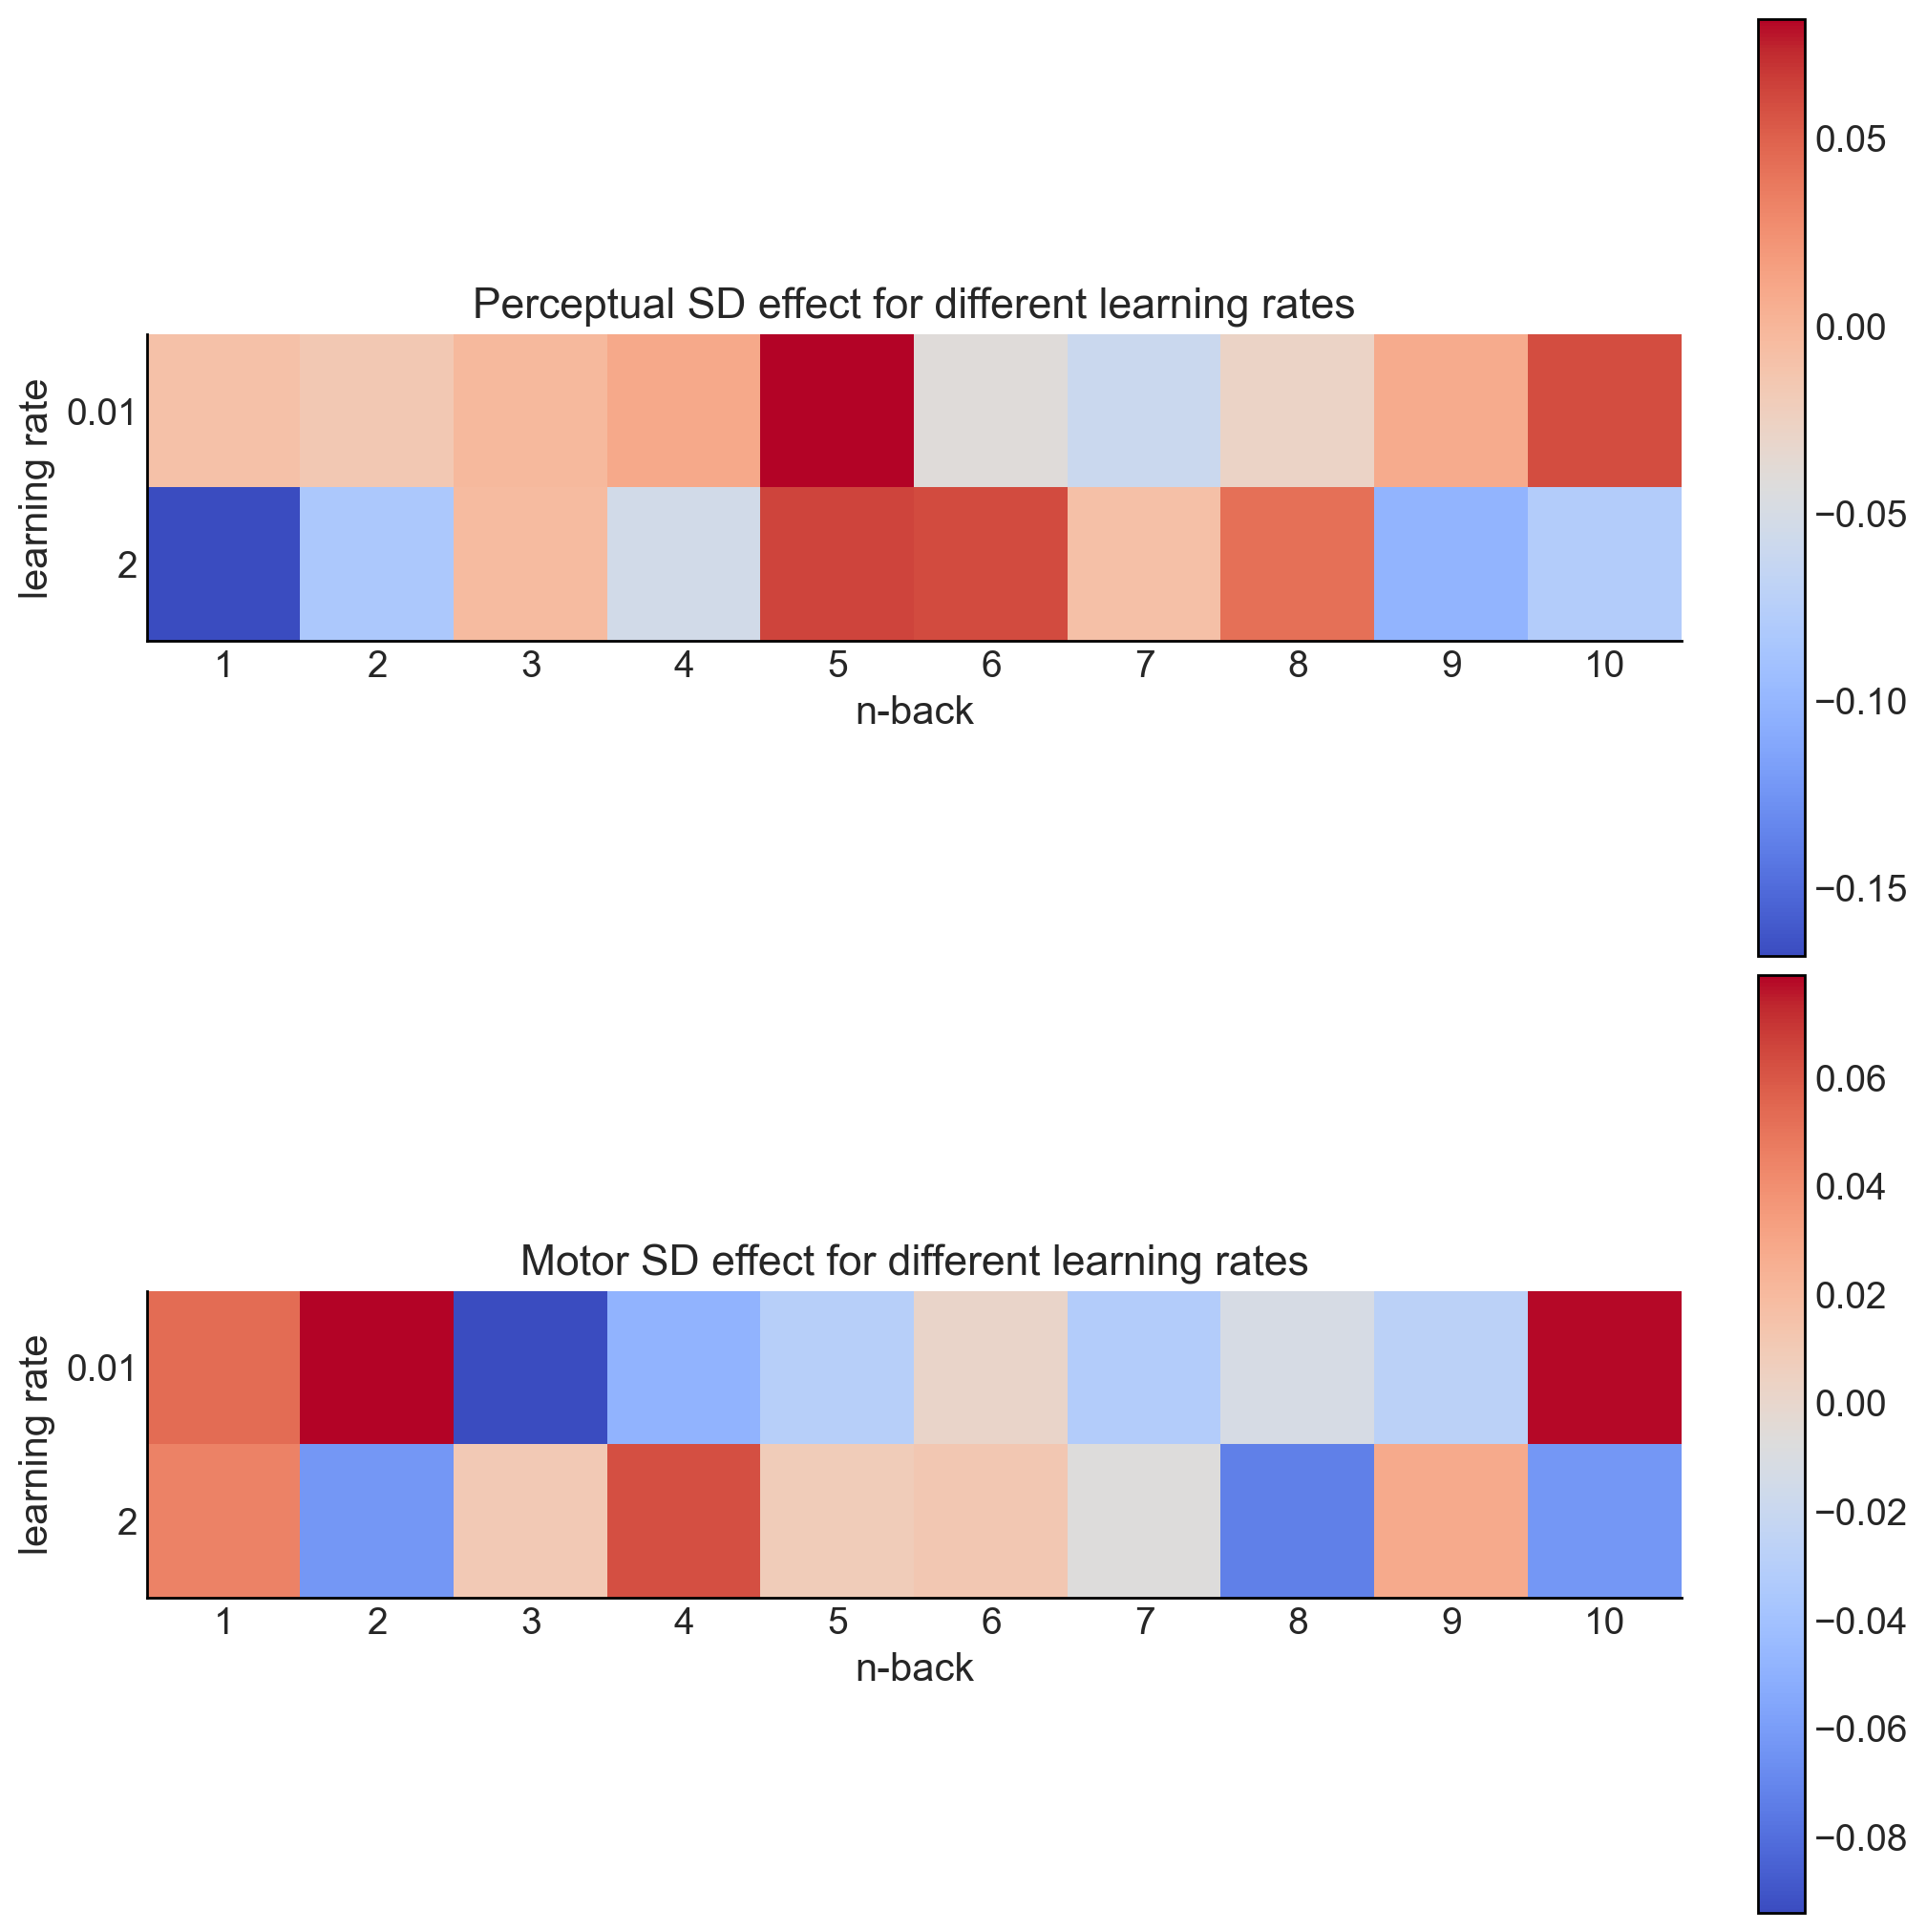

In [17]:
# visualize the SD matrix
# learning_rates = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1]

fig = plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.imshow(SD_Percept_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Perceptual SD effect for different learning rates')

plt.subplot(2,1,2)
plt.imshow(SD_Motor_alphas, cmap='coolwarm')
plt.colorbar()
plt.xlabel('n-back')
plt.ylabel('learning rate')
plt.xticks(range(10), range(1, 11))
plt.yticks(range(len(learning_rates)), learning_rates)
plt.title('Motor SD effect for different learning rates')
plt.show()